Run K-Nearest Neighbors and Decision Tree to predict credit spread

Data loaded from , shape=(309, 7)
Data after cleaning : (309, 7)


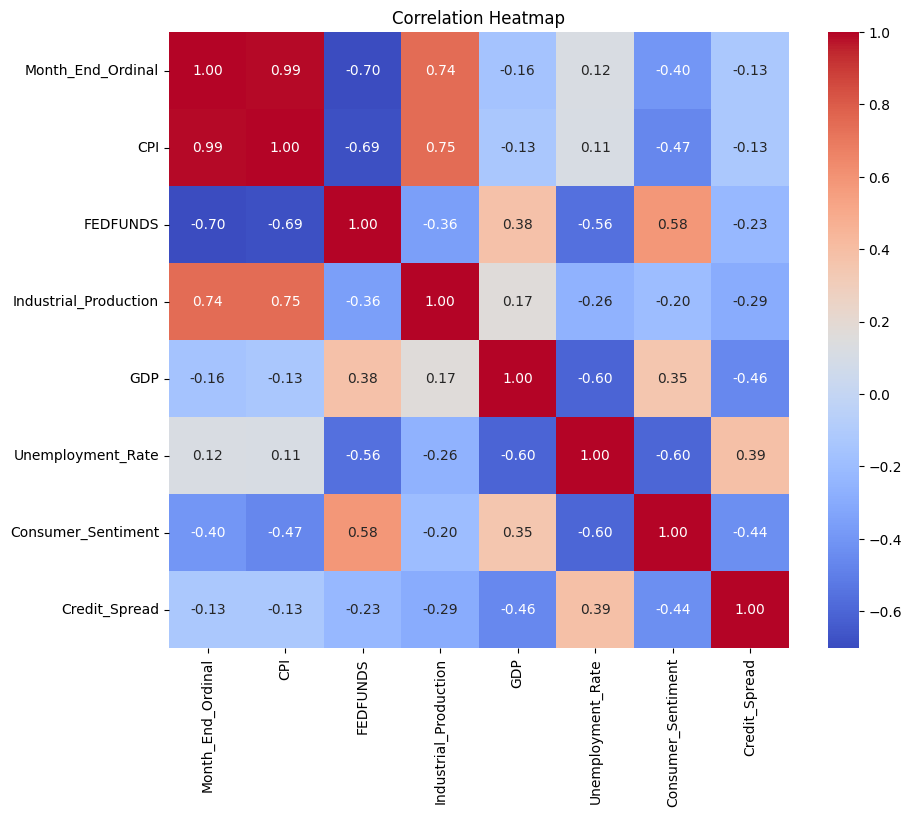

                 Feature         VIF
0      Month_End_Ordinal  210.394500
1                    CPI  205.776886
2               FEDFUNDS    4.160534
3  Industrial_Production    3.410280
4                    GDP    1.922157
5      Unemployment_Rate    3.759443
6     Consumer_Sentiment    5.786951


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
#########################################
# 1) Load or Reuse Cleaned Data
#########################################
df = pd.read_csv("../../data/merged_macroeconomic_credit.csv", parse_dates=['Month_End'], index_col='Month_End')
print(f"Data loaded from , shape={df.shape}")
df.dropna(inplace=True)
print("Data after cleaning :", df.shape)
#########################################
# 2) Handle the data
#########################################
##standarlize the data
df['Month_End_Ordinal']=df.index.map(pd.Timestamp.toordinal)
features = ['Month_End_Ordinal','CPI', 'FEDFUNDS', 'Industrial_Production', 'GDP', 'Unemployment_Rate', 'Consumer_Sentiment']
X = df[features].values
Y=df['Credit_Spread']
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)
##Correlation Heatmap
corr_df = df[features +['Credit_Spread']]
corr_matrix = corr_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()
##VIF matrix
vif_data = []
X_scaled_df=pd.DataFrame(X_scaled,columns=features)
for i in range(X_scaled_df.shape[1]):
    vif = variance_inflation_factor(X_scaled_df.values, i)
    vif_data.append((features[i], vif))

vif_df = pd.DataFrame(vif_data, columns=['Feature', 'VIF'])
print(vif_df)


As we can see in the heatmap,time shows extremely high correlations with several macroeconomic variables, such as CPI (0.99) and GDP (0.79). This indicates that these variables and the ordinal date index are both trending upward over time. Furthermore, we get the VIF of Month_End_Ordinal and CPI, which two variables exhibit extreme multicollinearity. Such high values indicate that they share a strong time trend with other features in the dataset.So we should handle the CPI and Month_ENd_ordinal columns.

In [8]:
df["CPI_Diff"] = df["CPI"].diff()
df = df.dropna()
features1 = ['Month_End_Ordinal', 'FEDFUNDS', 'Industrial_Production', 'GDP', 'Unemployment_Rate', 'Consumer_Sentiment','CPI_Diff']
X_diff= df[features1].values
Y=df['Credit_Spread']
scaler=StandardScaler()
X_scaled1=scaler.fit_transform(X_diff)
vif_data = []
X_scaled_diff=pd.DataFrame(X_scaled1,columns=features)
for i in range(X_scaled_diff.shape[1]):
    vif = variance_inflation_factor(X_scaled_diff.values, i)
    vif_data.append((features1[i], vif))

vif_df = pd.DataFrame(vif_data, columns=['Features1', 'VIF'])
print(vif_df)

               Features1       VIF
0      Month_End_Ordinal  4.769191
1               FEDFUNDS  3.616461
2  Industrial_Production  3.382330
3                    GDP  1.853689
4      Unemployment_Rate  3.460908
5     Consumer_Sentiment  2.109214
6               CPI_Diff  1.273014


We can notice that all VIFs smaller than 5, which means the multicollinearity has been solved. We can use this updated dataset to predict our target now.

Best k-NN Parameters: {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best k-NN CV MSE: 0.644489354978404
k-NN Test MSE: 3.267942348997079
k-NN Test R²: 0.6527061566004779


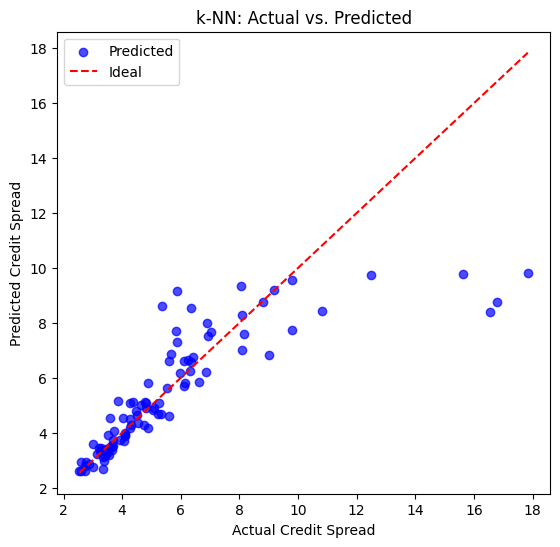

In [9]:
# 3) split the data
#########################################
X_train, X_test,Y_train,Y_test= train_test_split(X_scaled1,Y,test_size=0.3,random_state=42)
#########################################
# 4) K_Nearest Neighbors Regression
#########################################
##Hyperparameter Tuning for k-NN
knn=KNeighborsRegressor()
param_grid_knn={ 'n_neighbors': list(range(1, 21)),    
    'weights': ['uniform', 'distance'],     
    'p': [1, 2],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Search algorithms
    'leaf_size': list(range(10,50,5)) }
grid_search_knn=GridSearchCV(KNeighborsRegressor(),param_grid_knn,cv=5,scoring='neg_mean_squared_error')
grid_search_knn.fit(X_train, Y_train)
print("Best k-NN Parameters:", grid_search_knn.best_params_)
print("Best k-NN CV MSE:", -grid_search_knn.best_score_)
best_knn=grid_search_knn.best_estimator_
##Evaluate k-NN on test set
y_pred_knn=best_knn.predict(X_test)
mse_knn = mean_squared_error(Y_test, y_pred_knn)
r2_knn = r2_score(Y_test, y_pred_knn)
print("k-NN Test MSE:", mse_knn)
print("k-NN Test R²:", r2_knn)
plt.figure(figsize=(14, 6))
#  Visualize Predictions vs. Actual Values
plt.subplot(1, 2, 1)
plt.scatter(Y_test, y_pred_knn, alpha=0.7, color='blue', label='Predicted')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', label='Ideal')
plt.xlabel("Actual Credit Spread")
plt.ylabel("Predicted Credit Spread")
plt.title("k-NN: Actual vs. Predicted")
plt.legend()

The mse and test R^2 shows that the best K_NN model is robust and has a relative strong predictive ability. , While the k-NN model captures much of the variance, the gap between CV and test performance suggests further tuning or alternative methods. Next we will try decision tree regression.

Best Decision Tree Parameters： {'ccp_alpha': 0.0, 'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'random'}
Best Decision Tree CV MSE:： 1.2669010838086954
DT test MSE： 2.368122932712998
DT test R²： 0.7483326120496443


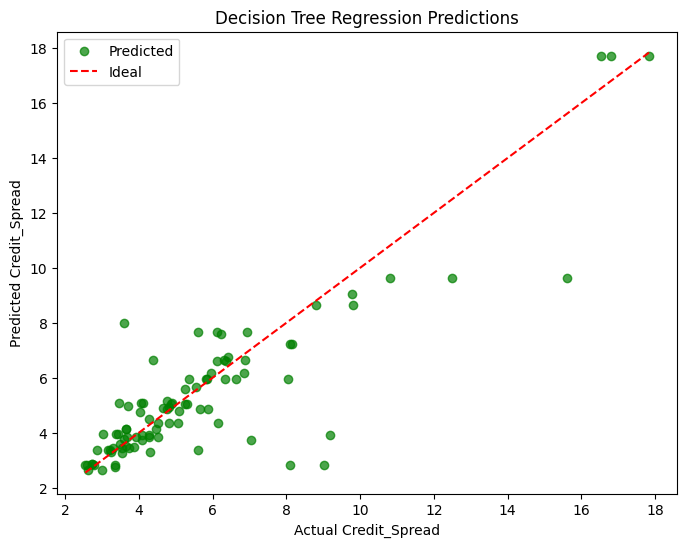

In [11]:
#########################################
# 5) Decision Tree Regression
#########################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
##Hyperparameter Tuning for DT
param_grid = {
    'max_depth': [None, 3, 5, 7, 10, 15, 20, 30],
    'min_samples_split': [2, 3, 5, 7, 10],
    'min_samples_leaf': [1, 2, 3, 5, 7, 10],
    'max_features': [None, 'sqrt', 'log2', 0.5],  
    'splitter': ['best', 'random'],
    'ccp_alpha': [0.0, 0.0001, 0.001, 0.01]      
}
dt_reg = DecisionTreeRegressor(random_state=42)
grid_search_dt = GridSearchCV(dt_reg, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_dt.fit(X_train, Y_train)
print("Best Decision Tree Parameters：", grid_search_dt.best_params_)
print("Best Decision Tree CV MSE:：", -grid_search_dt.best_score_)
best_dt = grid_search_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test)
##EvaluateDT on test set
test_mse = mean_squared_error(Y_test, y_pred_dt)
test_r2 = r2_score(Y_test, y_pred_dt)
print("DT test MSE：", test_mse)
print("DT test R²：", test_r2)
## Visualize Predictions vs. Actual Values
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, y_pred_dt, alpha=0.7, color='green', label='Predicted')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', label='Ideal')
plt.xlabel("Actual Credit_Spread")
plt.ylabel("Predicted Credit_Spread")
plt.title("Decision Tree Regression Predictions")
plt.legend()
plt.show()

The DT model fits training data well but exhibits signs of overfitting, especially for higher credit spread values. We can consider ensemble methods for improved generalization.